In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
def graficar(df: pd.DataFrame, feature, linea_cero=False):
    fig, ax = plt.subplots(figsize=[10,5])
    ax.plot(df[feature])
    if linea_cero:
        ax.axhline(y=0,color='grey',linestyle='--')

# Carga de datos
Se importa los datasets:
* JSTdatasetR5 de [http://data.macrohistory.net/JST/JSTdatasetR5.dta](http://data.macrohistory.net/JST/JSTdatasetR5.dta)
* WBdataset extraido de [https://databank.bancomundial.org/](https://databank.bancomundial.org/)

## JSTdatasetR5

In [3]:
df_jst = pd.read_stata("../data/JSTdatasetR5.dta")

In [4]:
df_jst.head()

,year,country,iso,ifs,pop,rgdpmad,rgdppc,rconpc,gdp,iy,...,eq_capgain,eq_dp,eq_capgain_interp,eq_tr_interp,eq_dp_interp,bond_rate,eq_div_rtn,capital_tr,risky_tr,safe_tr
0,1870.0,Australia,AUS,193,1775.0,3273.239437,13.836157,21.449734,208.78,0.109266,...,-0.070045,0.071417,NaN,NaN,NaN,0.049118,0.066415,NaN,NaN,NaN
1,1871.0,Australia,AUS,193,1675.0,3298.507463,13.936864,19.930801,211.56,0.104579,...,0.041654,0.065466,NaN,NaN,NaN,0.048446,0.068193,NaN,NaN,NaN
2,1872.0,Australia,AUS,193,1722.0,3553.426249,15.044247,21.085006,227.40,0.130438,...,0.108945,0.062997,NaN,NaN,NaN,0.047373,0.069861,NaN,NaN,NaN
3,1873.0,Australia,AUS,193,1769.0,3823.629169,16.219443,23.254910,266.54,0.124986,...,0.083086,0.064484,NaN,NaN,NaN,0.046720,0.069842,NaN,NaN,NaN
4,1874.0,Australia,AUS,193,1822.0,3834.796926,16.268228,23.458050,287.58,0.141960,...,0.119389,0.063503,NaN,NaN,NaN,0.046533,0.071085,NaN,NaN,NaN


In [5]:
df_jst.tail()

,year,country,iso,ifs,pop,rgdpmad,rgdppc,rconpc,gdp,iy,...,eq_capgain,eq_dp,eq_capgain_interp,eq_tr_interp,eq_dp_interp,bond_rate,eq_div_rtn,capital_tr,risky_tr,safe_tr
2659,2013.0,USA,USA,111,315820.328999,31571.993947,103.425299,101.892671,16784.851,0.192086,...,0.271035,0.019355,NaN,NaN,NaN,0.023508,0.024601,0.139843,0.212405,-0.065168
2660,2014.0,USA,USA,111,318106.646578,32113.618881,105.186253,104.113597,17527.258,0.196377,...,0.136350,0.019199,NaN,NaN,NaN,0.025408,0.021817,0.130063,0.132729,0.122398
2661,2015.0,USA,USA,111,320413.930388,32800.923063,107.421590,107.192931,18224.780,0.198301,...,-0.000092,0.021124,NaN,NaN,NaN,0.021358,0.021122,0.046193,0.065433,-0.008779
2662,2016.0,USA,USA,111,322705.239927,33078.508719,108.318698,109.333457,18715.040,0.195831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2663,2017.0,USA,USA,111,324802.861426,33593.446309,110.013284,111.389150,19519.424,0.204547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_jst.isna().sum().sort_values()

year                           0
country                        0
iso                            0
ifs                            0
peg_type                       0
peg_base                       0
crisisJST                     50
peg                           50
peg_strict                    50
pop                           51
cpi                           52
rgdpmad                       52
rgdppc                        52
xrusd                         53
gdp                           77
ltrate                        87
imports                      115
exports                      115
narrowm                      115
crisisJST_old                148
expenditure                  155
rconpc                       156
revenue                      174
stir                         198
money                        201
debtgdp                      229
ca                           229
tloans                       250
iy                           293
lev                          362
bond_rate 

### Preprocesado

In [7]:
features = np.array(['year','iso','pop','rgdpmad','ca','imports',
'exports','revenue','expenditure','debtgdp','narrowm','stir','ltrate','cpi'])

In [8]:
def preprocesarJST(df : pd.DataFrame):
    paises = df.iso.unique()
    df_r = pd.DataFrame()
    for pais in paises:
        df_n = df[df.iso==pais][features].copy()
        df_n = df_n.astype({'year': np.int16})
        #Fija year como indice
        df_n = df_n.set_index('year')
        #interpola datos faltantes en la serie
        df_n = df_n.interpolate(method='quadratic')
        #Calcula el PBI real usando el PBI per capita y la poblacion
        df_n['rgdp'] = df_n['rgdpmad']*df_n['pop']
        #calcula el ratio de crecimiento del PBI real
        df_n['rgdp_growth'] = df_n['rgdp'].pct_change()
        df_n['infl_cpi'] = df_n['cpi'].pct_change()
        #elimina filas con datos faltantes en los extremos
        df_n = df_n.dropna()

        df_r = df_r.append(df_n)
    return df_r

In [9]:
df_jst = preprocesarJST(df_jst)

In [10]:
df_jst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2330 entries, 1902 to 2017
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   iso          2330 non-null   object 
 1   pop          2330 non-null   float64
 2   rgdpmad      2330 non-null   float64
 3   ca           2330 non-null   float64
 4   imports      2330 non-null   float64
 5   exports      2330 non-null   float64
 6   revenue      2330 non-null   float64
 7   expenditure  2330 non-null   float64
 8   debtgdp      2330 non-null   float64
 9   narrowm      2330 non-null   float64
 10  stir         2330 non-null   float64
 11  ltrate       2330 non-null   float64
 12  cpi          2330 non-null   float64
 13  rgdp         2330 non-null   float64
 14  rgdp_growth  2330 non-null   float64
 15  infl_cpi     2330 non-null   float64
dtypes: float64(15), object(1)
memory usage: 309.5+ KB


## WBdataset

In [11]:
df_wb = pd.read_csv('../data/WBdataset.csv')

In [12]:
df_wb.head()

,país Code,tiempo Code,NY.GDP.MKTP.KD,NE.TRD.GNFS.ZS,NE.EXP.GNFS.ZS,NE.GDI.FTOT.ZS,NE.CON.GOVT.ZS,NE.IMP.GNFS.ZS,NV.IND.TOTL.ZS,NV.IND.MANF.ZS,FR.INR.RINR,FP.CPI.TOTL,FM.LBL.BMNY.GD.ZS,FM.LBL.BMNY.ZG,SL.UEM.TOTL.NE.ZS,SL.UEM.TOTL.ZS,SL.EMP.TOTL.SP.NE.ZS,SL.EMP.TOTL.SP.ZS
0,ARG,YR1960,1.507978e+11,15.208096,7.604049,23.478768,9.880445,7.604047,NaN,NaN,NaN,NaN,21.139251,NaN,NaN,NaN,NaN,NaN
1,ARG,YR1961,1.589829e+11,11.989892,5.994947,27.765895,7.789632,5.994945,NaN,NaN,NaN,NaN,16.605999,-0.359712,NaN,NaN,NaN,NaN
2,ARG,YR1962,1.576283e+11,14.075526,4.691843,21.730503,12.192375,9.383683,NaN,NaN,NaN,NaN,14.310117,10.108303,NaN,NaN,NaN,NaN
3,ARG,YR1963,1.492611e+11,15.780906,7.890454,18.272516,10.252195,7.890452,NaN,NaN,NaN,NaN,16.017618,33.114754,NaN,NaN,NaN,NaN
4,ARG,YR1964,1.643817e+11,11.127430,5.563716,17.178900,7.229026,5.563714,NaN,NaN,NaN,NaN,15.967860,41.379310,NaN,NaN,NaN,NaN


In [13]:
df_wb.tail()

,país Code,tiempo Code,NY.GDP.MKTP.KD,NE.TRD.GNFS.ZS,NE.EXP.GNFS.ZS,NE.GDI.FTOT.ZS,NE.CON.GOVT.ZS,NE.IMP.GNFS.ZS,NV.IND.TOTL.ZS,NV.IND.MANF.ZS,FR.INR.RINR,FP.CPI.TOTL,FM.LBL.BMNY.GD.ZS,FM.LBL.BMNY.ZG,SL.UEM.TOTL.NE.ZS,SL.UEM.TOTL.ZS,SL.EMP.TOTL.SP.NE.ZS,SL.EMP.TOTL.SP.ZS
3839,GBR,YR2017,3.088030e+12,61.354757,30.045686,18.018943,18.529638,31.309071,17.829685,8.947602,NaN,114.943592,144.271087,8.296332,4.33,4.330,60.180000,60.186001
3840,GBR,YR2018,3.139011e+12,62.314223,30.506397,17.773526,18.352082,31.807826,17.906024,8.846982,NaN,117.579064,146.520893,5.299826,4.00,4.000,60.560001,60.556999
3841,GBR,YR2019,3.191493e+12,62.927269,31.004978,17.718796,18.800567,31.922291,17.981247,8.879728,NaN,119.622711,139.337724,-1.364158,3.74,3.740,60.849998,60.855999
3842,GBR,YR2020,2.891616e+12,56.108854,28.120834,17.106203,22.347195,27.988020,17.024908,8.648937,NaN,120.806362,160.150856,9.706440,NaN,4.472,NaN,59.991001
3843,GBR,YR2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.848715,NaN,NaN,NaN,4.526,NaN,59.653999


In [14]:
names = {
    'país Code'             : 'iso',
    'tiempo Code'           : 'year',
    'FP.CPI.TOTL'           : 'cpi',
    'NY.GDP.MKTP.KD'        : 'rgdp',
    'NE.TRD.GNFS.ZS'        : 'trade',
    'NE.EXP.GNFS.ZS'        : 'exports',
    'NE.IMP.GNFS.ZS'        : 'imports',
    'NE.CON.GOVT.ZS'        : 'ggfce',
    'NE.GDI.FTOT.ZS'        : 'gfcf',
    'NV.IND.TOTL.ZS'        : 'industry',
    'NV.IND.MANF.ZS'        : 'manufact',
    'FM.LBL.BMNY.ZG'        : 'money',
    'FM.LBL.BMNY.GD.ZS'     : 'money_growth',
    'SL.UEM.TOTL.NE.ZS'     : 'unempl_nat',
    'SL.EMP.TOTL.SP.NE.ZS'  : 'unempl_ilo',
    'SL.UEM.TOTL.ZS'        : 'emplpop_nat',
    'SL.EMP.TOTL.SP.ZS'     : 'emplpop_ilo',
    'FR.INR.RINR'           : 'rir'
}

In [15]:
df_wb = df_wb.rename(columns=names)

In [16]:
df_wb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3844 entries, 0 to 3843
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   iso           3844 non-null   object 
 1   year          3844 non-null   object 
 2   rgdp          3268 non-null   float64
 3   trade         3256 non-null   float64
 4   exports       3256 non-null   float64
 5   gfcf          3174 non-null   float64
 6   ggfce         3229 non-null   float64
 7   imports       3256 non-null   float64
 8   industry      2725 non-null   float64
 9   manufact      2602 non-null   float64
 10  rir           1371 non-null   float64
 11  cpi           3402 non-null   float64
 12  money_growth  2507 non-null   float64
 13  money         2537 non-null   float64
 14  unempl_nat    2374 non-null   float64
 15  emplpop_nat   1922 non-null   float64
 16  unempl_ilo    1983 non-null   float64
 17  emplpop_ilo   1922 non-null   float64
dtypes: float64(16), object(2)
me

In [17]:
df_wb.describe()

,rgdp,trade,exports,gfcf,ggfce,imports,industry,manufact,rir,cpi,money_growth,money,unempl_nat,emplpop_nat,unempl_ilo,emplpop_ilo
count,3.268000e+03,3256.000000,3256.000000,3174.000000,3229.000000,3256.000000,2725.000000,2602.000000,1371.000000,3.402000e+03,2507.000000,2537.000000,2374.000000,1922.000000,1983.000000,1922.000000
mean,6.544747e+11,65.763825,32.309219,22.229651,15.255335,33.454606,27.914456,16.502522,6.122038,5.711510e+01,52.768564,34.973941,7.082949,7.088873,55.900207,56.223363
std,1.814907e+12,47.195125,24.769255,6.311443,5.253687,23.023139,8.119055,5.160703,11.524244,6.673585e+01,38.247796,227.428636,4.121736,4.049256,8.651281,8.200435
min,9.488899e+08,4.920835,2.055800,0.000000,0.911235,2.132769,6.064102,3.983848,-69.106317,3.572040e-10,0.000000,-50.812027,0.200000,0.400000,18.160000,30.597000
25%,3.682834e+10,35.908404,16.697031,18.406419,11.242478,18.890536,22.589871,13.094242,1.905376,1.068320e+01,26.487935,8.150479,4.072500,4.086000,50.344999,50.819251
50%,1.536684e+11,54.184135,26.156127,21.792504,15.263154,27.883107,26.613235,16.160458,4.795418,5.362549e+01,42.245298,14.058384,6.310000,6.160000,56.630001,57.004000
75%,4.702011e+11,79.452184,39.879829,25.300362,19.077478,40.385401,31.496860,19.363669,9.050285,9.414793e+01,65.360776,23.348018,9.137500,9.157500,61.305000,60.943000
max,1.997453e+13,380.104207,205.482078,89.386126,34.310433,174.622130,64.009784,41.184160,139.963569,2.740274e+03,280.185805,6987.876844,27.469999,27.469999,87.360001,77.071999


In [18]:
df_wb = df_wb.drop(labels=['rir','emplpop_nat','unempl_ilo','emplpop_ilo','money','money_growth'],axis=1)

In [19]:
df_com_sp = pd.read_csv('../data/com_sp.csv',sep=';')
df_com_sp.head()

,year,oil,gold,copper,sp500
0,1960,8.514978,184.247397,3545.761145,578.91
1,1961,8.045025,180.628741,3244.062298,585.77
2,1962,7.646138,177.219364,3245.299218,672.96
3,1963,7.686329,179.808866,3309.993923,625.55
4,1964,7.327570,177.377723,4900.644952,723.17


In [20]:
df_com_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    62 non-null     int64  
 1   oil     62 non-null     float64
 2   gold    62 non-null     float64
 3   copper  62 non-null     float64
 4   sp500   62 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.5 KB


In [21]:
def preprocesarComSP(df : pd.DataFrame):
    df = df.astype({'year': np.int16})
    #Fija year como indice
    df = df.set_index('year')
    #escala logaritmica
    df['oil'] = np.log10(df['oil'])
    df['gold'] = np.log10(df['gold'])
    df['copper'] = np.log10(df['copper'])
    df['sp500'] = np.log10(df['sp500'])
    return df

In [22]:
def preprocesarWB(df : pd.DataFrame, df2 : pd.DataFrame):
    paises = df.iso.unique()
    df_r = pd.DataFrame()
    for pais in paises:
        df_n = df[df.iso==pais].copy()
        df_n['year'] = pd.to_numeric(df_n['year'].str.replace('YR',''),downcast='integer')
        #df_n = df_n.astype({'year': np.int16})
        #Fija year como indice
        df_n = df_n.set_index('year')
        #interpola datos faltantes en la serie
        df_n = df_n.interpolate(method='quadratic')
        #calcula el ratio de crecimiento del PBI real
        df_n['rgdp_growth'] = df_n['rgdp'].pct_change()
        df_n['rgdp'] = np.log10(df_n['rgdp'])
        df_n['infl_cpi'] = df_n['cpi'].pct_change()
        df_n['cpi'] = np.log10(df_n['cpi'])
        #elimina filas con datos faltantes en los extremos
        df_n = df_n.dropna()
        #Une con el data frame 2
        df_n = pd.merge(left=df_n, right=df2, left_on='year',right_on='year')

        df_r = df_r.append(df_n)
    return df_r

In [23]:
df_com_sp = preprocesarComSP(df_com_sp)

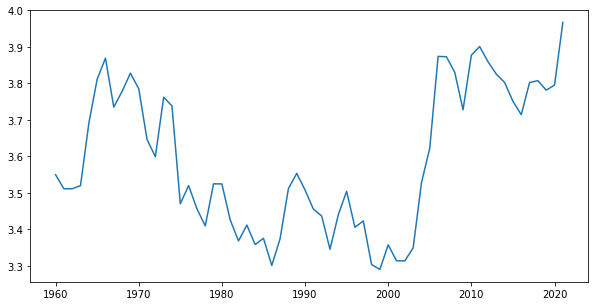

In [24]:
graficar(df_com_sp,'copper')

In [25]:
df_wb = preprocesarWB(df_wb,df_com_sp)

In [26]:
df_wb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054 entries, 1990 to 2019
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   iso          2054 non-null   object 
 1   rgdp         2054 non-null   float64
 2   trade        2054 non-null   float64
 3   exports      2054 non-null   float64
 4   gfcf         2054 non-null   float64
 5   ggfce        2054 non-null   float64
 6   imports      2054 non-null   float64
 7   industry     2054 non-null   float64
 8   manufact     2054 non-null   float64
 9   cpi          2054 non-null   float64
 10  unempl_nat   2054 non-null   float64
 11  rgdp_growth  2054 non-null   float64
 12  infl_cpi     2054 non-null   float64
 13  oil          2054 non-null   float64
 14  gold         2054 non-null   float64
 15  copper       2054 non-null   float64
 16  sp500        2054 non-null   float64
dtypes: float64(16), object(1)
memory usage: 288.8+ KB


### Guardar

In [27]:
df_wb.to_csv('../data/wb_dataset_prep.csv')

In [37]:
df_wb['iso'].unique()

array(['AUS', 'AUT', 'BGD', 'BEL', 'BOL', 'BRA', 'CAN', 'CHL', 'CHN',
       'COL', 'CRI', 'HRV', 'DNK', 'ECU', 'EGY', 'SLV', 'EST', 'FIN',
       'FRA', 'DEU', 'GTM', 'GRC', 'HND', 'ISL', 'HUN', 'IRL', 'IDN',
       'ISR', 'IND', 'ITA', 'JOR', 'JPN', 'KEN', 'KOR', 'LTU', 'MYS',
       'MLT', 'MEX', 'MAR', 'NGA', 'LUX', 'NLD', 'PAK', 'PAN', 'NOR',
       'PRT', 'PRY', 'PER', 'POL', 'ESP', 'USA', 'RUS', 'ROU', 'SWE',
       'TUR', 'URY', 'VNM', 'CHE', 'GBR'], dtype=object)

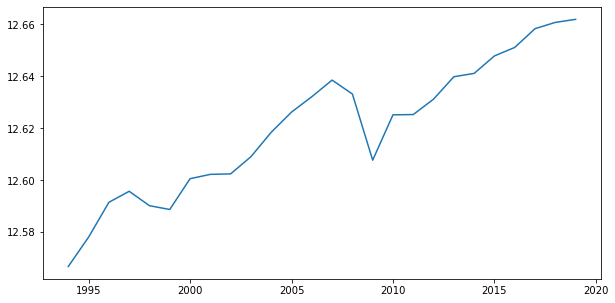

In [29]:
graficar(df_wb[df_wb.iso=='JPN'],'rgdp')

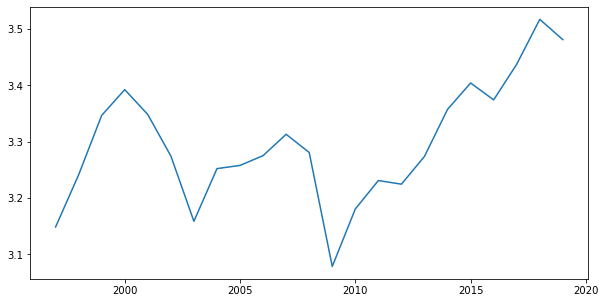

In [30]:
graficar(df_wb[df_wb.iso=='USA'],'sp500')

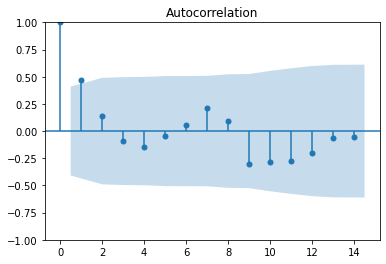

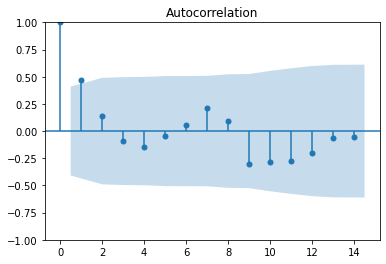

In [31]:
plot_acf(df_wb[df_wb.iso=='USA']['rgdp_growth'])

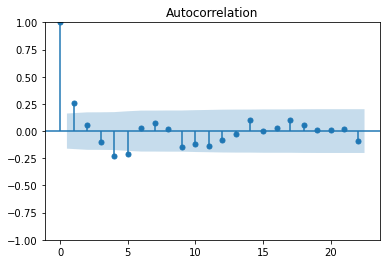

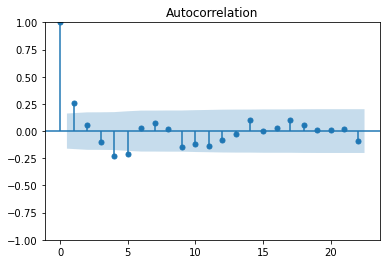

In [32]:
plot_acf(df_jst[df_jst.iso=='USA']['rgdp_growth'])

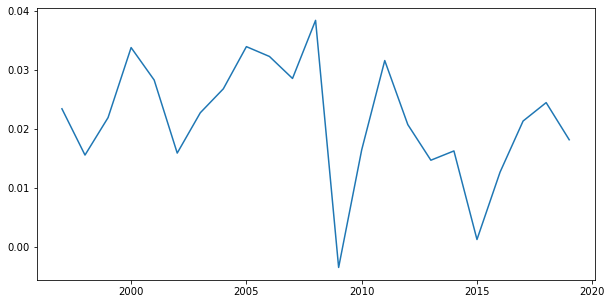

In [33]:
graficar(df_wb[df_wb.iso=='USA'],'infl_cpi')

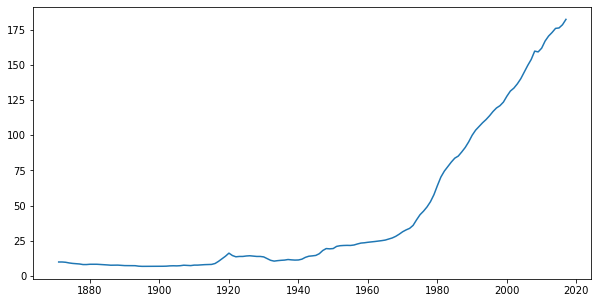

In [34]:
graficar(df_jst[df_jst.iso=='USA'],'cpi')

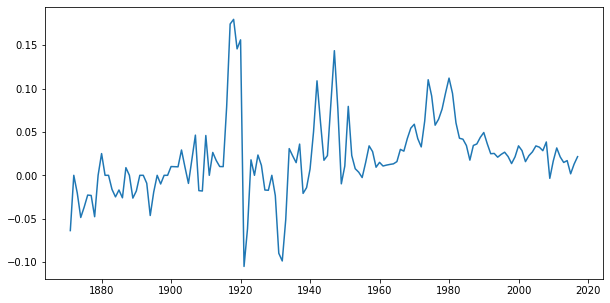

In [35]:
graficar(df_jst[df_jst.iso=='USA'],'infl_cpi')